# Tune MNIST Predictor

This notebook aims to tune the MLP Keras model created on `train_mnist_predictor`

## Predict digits 

In [1]:
# Change the reference dir to the root folder
import os
os.chdir('../')

In [2]:
import tensorflow as tf

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from utils import plot_numbers, get_accuracy_by_digit

In [3]:


X, y = np.load('data/new_img_array.npy'), np.load('data/new_y_true.npy')

In [4]:
# Count numbers in database
pd.Series(y).value_counts().sort_values(ascending=False)

5    65
2    58
6    53
8    48
3    41
1    39
4     5
9     4
7     4
0     3
dtype: int64

In [5]:
# Frequency in % of numbers in database
(pd.Series(y).value_counts() / len(y)).sort_values(ascending=False)

5    0.203125
2    0.181250
6    0.165625
8    0.150000
3    0.128125
1    0.121875
4    0.015625
9    0.012500
7    0.012500
0    0.009375
dtype: float64

In [6]:
X_train_full, X_test_full, y_train_full, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)

In [7]:
X_train_full.min(), X_train_full.max()

(0, 255)

The train set contains 60,000 images in 28x28 array. Each element of the array represents the pixel intensity of the image, ranging from 1 to 255

Let's see some of the pictures of the dataset

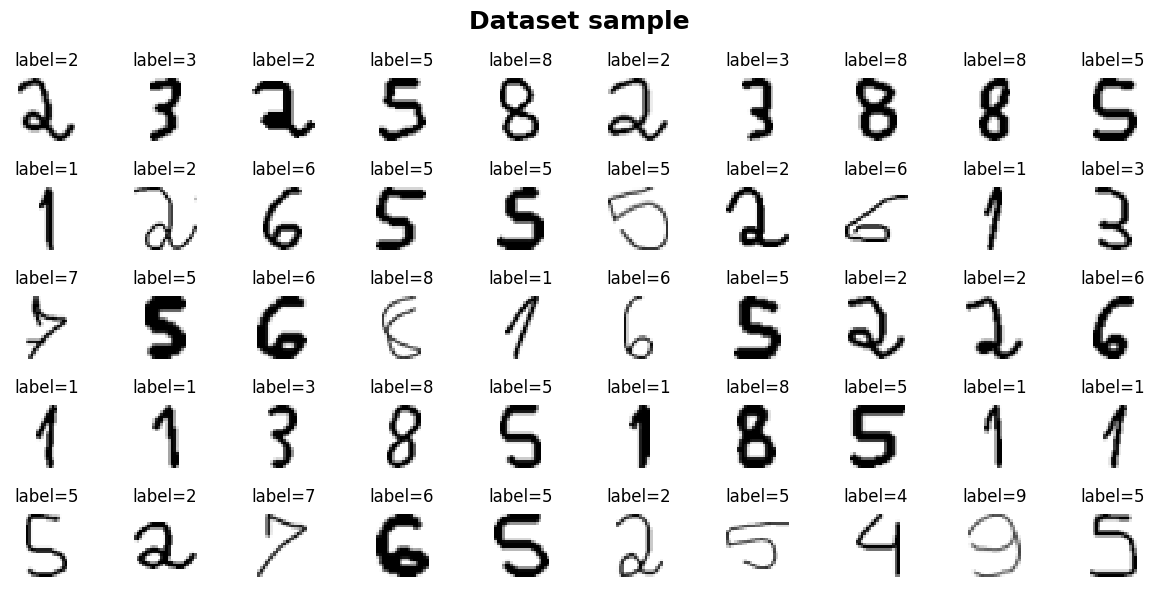

In [8]:
plot_numbers(X_train_full, true_label=y_train_full, title='Dataset sample', n_rows=5);

Normalizing array and creating validation set (the data is already shuffled)

In [9]:
# Creating validation set
X_train, X_valid = X_train_full[y_test.shape[0]:], X_train_full[:y_test.shape[0]]
y_train, y_valid = y_train_full[y_test.shape[0]:], y_train_full[:y_test.shape[0]]

In [10]:
# Normalizing values from 0-255 to 0-1
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test_full / 255.

## Data Augmentation

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)

In [13]:
# train_generator = datagen.flow(X_train, y_train, batch_size=32)

**IN WORKS**

In [14]:
retrain = True

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(units=200, activation='relu'),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='softmax')
]
)

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 200)               157000    
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 10)                510       
                                                                 
Total params: 182,660
Trainable params: 182,660
Non-trainable params: 0
_________________________________________________________________


In [19]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("./models/tuned-mnist.h5", save_best_only=True)

In [20]:
if retrain:
    history = model.fit(X_train, y_train, batch_size=32, validation_data=(X_valid, y_valid), epochs=100,
                        callbacks=[early_stopping_cb, checkpoint_cb])
else:
    model = tf.keras.models.load_model('./models/tuned-mnist.h5')

Epoch 1/100
8/8 [==============================] - 1s 26ms/step - loss: 1.8977 - accuracy: 0.3320 - val_loss: 1.3133 - val_accuracy: 0.6250
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 1.0172 - accuracy: 0.8281 - val_loss: 0.6245 - val_accuracy: 0.8438
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.5619 - accuracy: 0.8516 - val_loss: 0.5065 - val_accuracy: 0.8125
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.3952 - accuracy: 0.8828 - val_loss: 0.4011 - val_accuracy: 0.8750
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 0.2991 - accuracy: 0.9141 - val_loss: 0.4077 - val_accuracy: 0.9062
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 0.2017 - accuracy: 0.9492 - val_loss: 0.3561 - val_accuracy: 0.9062
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 0.1417 - accuracy: 0.9648 - val_loss: 0.3931 - val_accuracy: 0.8750
Epoch 8/100
8/8 [=========

In [21]:
model = tf.keras.models.load_model('models/tuned-mnist.h5')

In [22]:
if retrain:
    model.save("models/tuned-mnist.h5")

In [23]:
y_pred = np.argmax(model.predict(X_test), axis=1)

1/1 [==============================] - 0s 62ms/step


In [24]:
print('Metrics:')
print(classification_report(y_test, y_pred))

Metrics:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       1.00      0.71      0.83         7
           3       0.80      1.00      0.89         4
           4       0.00      0.00      0.00         2
           5       0.80      1.00      0.89         4
           6       0.83      0.83      0.83         6
           8       0.67      1.00      0.80         4

    accuracy                           0.84        32
   macro avg       0.73      0.79      0.75        32
weighted avg       0.81      0.84      0.82        32



C:\Users\gugat\PycharmProjects\Draw2Text\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gugat\PycharmProjects\Draw2Text\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gugat\PycharmProjects\Draw2Text\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [25]:
from sklearn.metrics import accuracy_score

In [26]:
df2 = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test, 'right': y_pred == y_test})

In [27]:
df2.groupby('y_test')['right'].sum() / df2.groupby('y_test')['right'].count()

y_test
1    1.000000
2    0.714286
3    1.000000
4    0.000000
5    1.000000
6    0.833333
8    1.000000
Name: right, dtype: float64

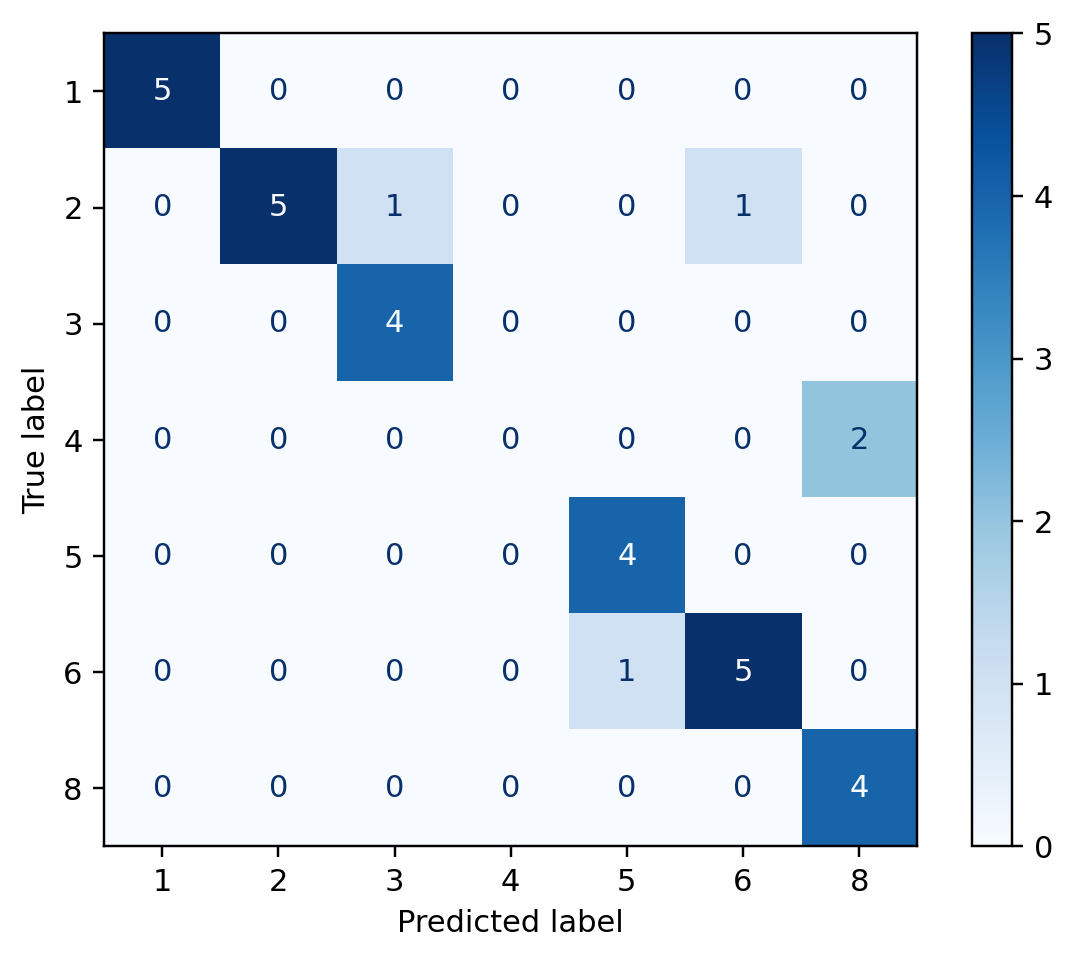

In [28]:
fig, ax = plt.subplots(dpi=220)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', ax=ax)
plt.show()

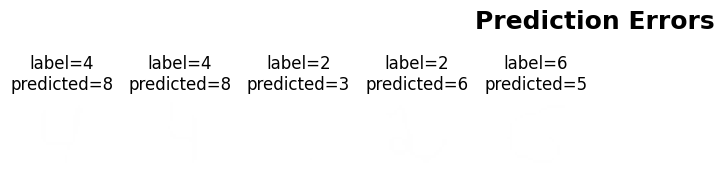

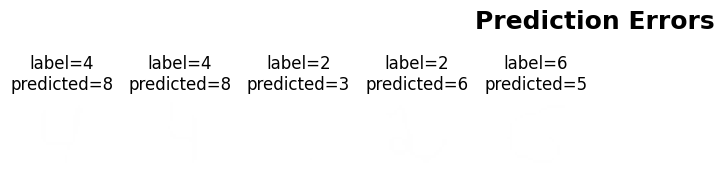

In [29]:
plot_numbers(
    img_array=X_test[y_pred != y_test],
    true_label=y_test[y_pred != y_test],
    predicted_label=y_pred[y_pred != y_test],
    title='Prediction Errors'
)

## Fine tune model

In [30]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [31]:
# Baseline model from previous notebook
model = tf.keras.models.load_model('models/default_mnist_model.h5')

In [32]:
y_pred = np.argmax(model.predict(X_test), axis=1)

1/1 [==============================] - 0s 40ms/step


In [41]:
minist_acc = get_accuracy_by_digit(y_test, y_pred)
minist_acc

y_true
1    1.000000
2    0.857143
3    0.750000
4    1.000000
5    1.000000
6    0.833333
8    1.000000
Name: right, dtype: float64

In [34]:
y_pred

array([2, 5, 6, 4, 9, 8, 8, 3, 2, 5, 3, 4, 5, 5, 2, 3, 5, 6, 8, 2, 9, 2,
       1, 3, 5, 6, 3, 6, 3, 3, 8, 2], dtype=int64)

In [35]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("models/tuned-mnist.h5", save_best_only=True)

In [36]:
history = model.fit(X_train, y_train, batch_size=32, validation_data=(X_valid, y_valid), epochs=100,
                     callbacks=[early_stopping_cb, checkpoint_cb])

Epoch 1/100
8/8 [==============================] - 0s 22ms/step - loss: 4.9992 - accuracy: 0.3945 - val_loss: 1.0208 - val_accuracy: 0.7500
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.8959 - accuracy: 0.6953 - val_loss: 0.4786 - val_accuracy: 0.8438
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.4845 - accuracy: 0.8438 - val_loss: 0.2805 - val_accuracy: 0.9062
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 0.2543 - accuracy: 0.9375 - val_loss: 0.2454 - val_accuracy: 0.9375
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1578 - accuracy: 0.9648 - val_loss: 0.2248 - val_accuracy: 0.9062
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 0.1041 - accuracy: 0.9844 - val_loss: 0.2232 - val_accuracy: 0.8750
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0710 - accuracy: 0.9922 - val_loss: 0.2192 - val_accuracy: 0.9375
Epoch 8/100
8/8 [=========

In [37]:
model = tf.keras.models.load_model('models/tuned-mnist.h5')

In [38]:
y_pred = np.argmax(model.predict(X_test), axis=1)

1/1 [==============================] - 0s 40ms/step


In [39]:
get_accuracy_by_digit(y_test, y_pred)

y_true
1    1.000000
2    0.857143
3    0.750000
4    1.000000
5    1.000000
6    0.833333
8    1.000000
Name: right, dtype: float64

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       1.00      0.86      0.92         7
           3       1.00      0.75      0.86         4
           4       1.00      1.00      1.00         2
           5       0.80      1.00      0.89         4
           6       0.83      0.83      0.83         6
           8       0.80      1.00      0.89         4

    accuracy                           0.91        32
   macro avg       0.92      0.92      0.91        32
weighted avg       0.92      0.91      0.91        32

